<a href="https://colab.research.google.com/github/SERVIR/GEDI_Earthhub_ARSET_Training/blob/main/how_to_access_gedi_data_harmony.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accessing GEDI data using NASA Harmony API  



Harmony provides access to services that can transform data from NASA's [Earth Observing Systems Data and Information System (EOSDIS)](https://www.earthdata.nasa.gov/eosdis) Distributed Active Archive Centers (DAAC). [`harmony-py`](https://github.com/nasa/harmony-py) Python package is the recommended way of interacting with Harmony service. This notebook shows how to query and access customized [NASA's LP DAAC](https://lpdaac.usgs.gov/)  GEDI data outputs using [NASA's Harmony Services](https://harmony.earthdata.nasa.gov/).


## Authenticate

In [ ]:
!pip install geoviews earthaccess harmony-py hvplot

In [ ]:
from harmony import BBox, Client, Collection, Request, CapabilitiesRequest
from datetime import datetime
import json
import earthaccess
import geopandas as gp
import os
from IPython.display import JSON
import h5py
import pandas as pd
from shapely.geometry import Point
import hvplot.pandas

os.chdir('../../')

`earthaccess.login()` is used here to access NASA Earthdata Login (EDL) credentials stored in a .netrc file and allows users to type their credentials and persist them to a .netrc file if one does not exist.

In [ ]:
auth = earthaccess.login(persist=True)
# auth.token

Enter your Earthdata Login username: tjm0042
Enter your Earthdata password: ··········


To access data through Harmony service, we need to create a Harmony Client object using either your EDL token or your Earthdata Login credentials. Below, `username` and `password` are directly provided to `Client` function. See [here](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) for other options you can create Harmony Client object.

In [ ]:
harmony_client = Client(auth=(auth.username, auth.password))

## Get the GEDI Collections Harmoney Capabilities

Let us start by submitting a capabilities request to see the transformation supported in Harmony API using the GEDI product short names ('GEDI02_A', 'GEDI02_B', 'GEDI01_B'). Besides the `conceptId` and available variables, You can view the supported transformation services. Supported transformation services and variables (such as variable subsetting, bounding box subsetting, shapefile subsetting, concatenation and reprojection, etc.) have `True` value. Based on the returned capabilities information for GEDI , we can submit a variable subsetting request, bounding box/shapefile subsetting, and temporal subsetting.

In [ ]:
capabilities = harmony_client.submit(CapabilitiesRequest(short_name='GEDI02_B'))
print(json.dumps(capabilities, indent=2))

{
  "conceptId": "C2142776747-LPCLOUD",
  "shortName": "GEDI02_B",
  "variableSubset": true,
  "bboxSubset": true,
  "shapeSubset": true,
  "temporalSubset": true,
  "concatenate": false,
  "reproject": false,
  "outputFormats": [
    "application/x-hdf"
  ],
  "services": [
    {
      "name": "sds/trajectory-subsetter",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/S2836723123-XYZ_PROV",
      "capabilities": {
        "subsetting": {
          "temporal": true,
          "bbox": true,
          "shape": true,
          "variable": true
        },
        "output_formats": [
          "application/x-hdf"
        ]
      }
    }
  ],
  "variables": [
    {
      "name": "/BEAM0000/algorithmrun_flag",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/V2837647264-LPCLOUD"
    },
    {
      "name": "/BEAM0000/ancillary/dz",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/V2837647474-LPCLOUD"
    },
    {
      "name": "/BEAM0000/ancillary/l2a_al

## Create a Harmony Request

There are several parameters that can be used for the Harmony request. See [the documentation](https://harmony-py.readthedocs.io/en/latest/) and [the introductory Harmony tutorial ](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) for more details.


### GEDI Collection Concept ID

`collection` is a Required parameter. The concept ID, which is the NASA EOSDIS collection ID provided in the Common Metadata Repository (CMR) metadata **OR** Product short name (e.g. 'C2142776747-LPCLOUD') can be provided to search for collections.

Below, `concept_id` is saved to a variable.  

In [ ]:
print(capabilities['shortName'], ',', capabilities['conceptId'])

concept_id = capabilities['conceptId']


GEDI02_B , C2142776747-LPCLOUD


### GEDI Variable Subset

To learn more about the available layers, you can view the GEDI Dictionaries provided in [GEDI products' DOI Landing pages](https://lpdaac.usgs.gov/product_search/?query=gedi&status=Operational&view=cards&sort=title). The available GEDI datasets are also saved into a JSON file (`GEDI_Datasets.json`) stored in `data` folder and is used to view the available datasets here.



In [ ]:
field = {"GEDI_L1B": ["geolocation/altitude_instrument", "geolocation/local_beam_elevation", "tx_sample_start_index", "nsemean_odd", "ancillary/master_time_epoch", "noise_stddev_corrected", "tx_pulseflag", "geolocation/longitude_bin0_error", "selection_stretchers_x", "nsemean_even", "geolocation/latitude_instrument", "geolocation/digital_elevation_model", "geolocation/longitude_instrument_error", "geolocation/longitude_lastbin_error", "tx_egsigma", "geolocation/neutat_delay_total_bin0", "rx_energy", "master_frac", "rx_sample_count", "rxwaveform", "tx_gloc", "ancillary/mean_samples", "geolocation/longitude_instrument", "tx_eggamma_error", "rx_offset", "tx_egbias_error", "geolocation/bounce_time_offset_lastbin", "all_samples_sum", "geophys_corr/tide_load", "geolocation/solar_azimuth", "geolocation/mean_sea_surface", "geolocation/neutat_delay_total_lastbin", "th_left_used", "rx_sample_start_index", "geophys_corr/tide_ocean", "geophys_corr/tide_ocean_pole", "tx_eggamma", "geophys_corr/tide_pole", "tx_sample_count", "geolocation/surface_type", "geolocation/neutat_delay_derivative_bin0", "geolocation/digital_elevation_model_srtm", "shot_number", "txwaveform", "geolocation/latitude_bin0_error", "geolocation/altitude_instrument_error", "channel", "geolocation/longitude_lastbin", "geolocation/latitude_lastbin", "geolocation/elevation_bin0_error", "geolocation/shot_number", "geolocation/solar_elevation", "geolocation/local_beam_elevation_error", "tx_egamplitude", "geolocation/latitude_bin0", "geolocation/elevation_lastbin_error", "ancillary/smoothing_width", "geolocation/latitude_instrument_error", "tx_egbias", "geolocation/bounce_time_offset_bin0_error", "geolocation/bounce_time_offset_bin0", "rx_open", "beam", "geolocation/local_beam_azimuth", "tx_egflag", "tx_egsigma_error", "geolocation/bounce_time_offset_lastbin_error", "tx_gloc_error", "geophys_corr/geoid", "selection_stretchers_y", "geolocation/latitude_lastbin_error", "master_int", "geolocation/range_bias_correction", "geolocation/elevation_lastbin", "geolocation/longitude_bin0", "stale_return_flag", "geolocation/delta_time", "noise_mean_corrected", "geolocation/local_beam_azimuth_error", "geophys_corr/dynamic_atmosphere_correction", "geophys_corr/delta_time", "tx_egamplitude_error", "geolocation/elevation_bin0", "geolocation/neutat_delay_derivative_lastbin", "geolocation/degrade", "geophys_corr/tide_earth"], "GEDI_L2A": ["rx_processing_a4/ancillary/rx_subbin_resolution", "rx_processing_a6/ancillary/rx_use_fixed_thresholds", "rx_processing_a1/rx_iwaveamps", "rx_processing_a1/selected_mode_flag", "rx_processing_a2/sd_sm", "geolocation/elev_highestreturn_a2", "rx_processing_a2/zcross0", "geolocation/rh_a6", "rx_processing_a2/ancillary/preprocessor_threshold", "rx_processing_a4/ancillary/rx_max_mode_count", "geolocation/elevs_allmodes_a3", "rx_processing_a1/ancillary/rx_smoothing_width_zcross", "rx_processing_a6/sd_sm", "rx_processing_a3/rx_cumulative", "geolocation/quality_flag_a6", "lat_highestreturn", "rx_1gaussfit/ancillary/rx_constraint_gloc_upper", "rx_assess/ancillary/rx_pulsethresh", "rx_processing_a3/selected_mode", "rx_processing_a5/ancillary/enable_select_mode", "geolocation/elev_highestreturn_a1", "rx_processing_a1/toploc", "rx_1gaussfit/ancillary/rx_estimate_bias", "rx_processing_a1/search_start", "rx_processing_a6/ancillary/rx_subbin_resolution", "rx_processing_a6/zcross_localenergy", "geolocation/energy_lowestmode_a6", "master_frac", "rx_processing_a4/ancillary/ampval_limit3", "rx_processing_a6/selected_mode", "geolocation/lat_highestreturn_a4", "rx_processing_a1/ancillary/botlocdist_limit2", "rx_processing_a3/min_detection_energy", "rx_processing_a6/peak", "rx_processing_a5/rx_modelocalslope", "rx_processing_a6/ancillary/cumulative_energy_thresh", "geolocation/lon_lowestmode_a6", "rx_processing_a6/ancillary/pulse_sep_thresh", "rx_processing_a5/lastmodeenergy", "rx_1gaussfit/ancillary/rx_constraint_gamplitude_upper", "geolocation/elevs_allmodes_a5", "rx_assess/rx_energy", "rx_processing_a6/rx_cumulative", "delta_time", "rx_processing_a2/rx_modelocs", "rx_processing_a6/ancillary/rx_searchsize", "elev_lowestmode", "rx_processing_a3/selected_mode_flag", "rx_processing_a5/pk_sm", "rx_processing_a2/ancillary/rx_subbin_resolution", "rx_processing_a5/ancillary/botlocdist_limit2", "geolocation/lats_allmodes_a3", "geolocation/lat_highestreturn_a5", "geolocation/lon_lowestreturn_a6", "rx_processing_a1/energy_sm", "rx_processing_a5/stddev", "rx_processing_a2/ancillary/rx_use_fixed_thresholds", "geolocation/lon_lowestmode_a4", "rx_processing_a3/ancillary/rx_back_threshold", "geolocation/num_detectedmodes_a1", "rx_processing_a3/ancillary/botlocdist_limit3", "rx_processing_a1/ancillary/rx_searchsize", "rx_processing_a2/toploc_miss", "geolocation/lat_highestreturn_a6", "rx_processing_a3/ancillary/botlocdist_limit1", "rx_processing_a5/rx_modelocs", "rx_processing_a6/ancillary/botlocdist_limit3", "geolocation/lon_lowestreturn_a1", "geolocation/rh_a1", "land_cover_data/modis_nonvegetated_sd", "rx_processing_a1/rx_modeenergytobotloc", "rx_processing_a3/ancillary/pulse_sep_thresh", "rx_processing_a2/toploc", "rx_processing_a4/ancillary/rx_use_fixed_thresholds", "geolocation/sensitivity_a2", "rx_processing_a1/ancillary/energy_thresh", "rx_processing_a5/rx_modeenergytobotloc", "geolocation/lon_highestreturn_a6", "rx_processing_a1/min_detection_threshold", "rx_processing_a1/ancillary/rx_sentinel_location", "rx_processing_a1/rx_nummodes", "rx_processing_a6/zcross", "rx_processing_a4/rx_modeenergytobotloc", "selected_mode", "rx_processing_a5/botloc", "latitude_bin0_error", "rx_processing_a3/search_start", "rx_processing_a5/rx_modelocalenergyabovemean", "rx_1gaussfit/ancillary/mpfit_tolerance", "geolocation/lons_allmodes_a4", "rx_1gaussfit/rx_gwidth", "land_cover_data/pft_class", "rx_processing_a4/rx_cumulative", "geolocation/lat_lowestmode_a5", "rx_processing_a3/rx_algrunflag", "rx_processing_a3/ancillary/rx_smoothing_width_zcross", "rx_processing_a4/toploc", "rx_processing_a6/stddev", "rx_processing_a1/ancillary/ampval_limit2", "rx_assess/mean", "rx_processing_a4/botloc_amp", "geolocation/elev_lowestmode_a2", "rx_processing_a1/ancillary/preprocessor_threshold", "rx_processing_a5/smoothwidth_zcross", "rx_processing_a1/zcross", "rx_processing_a1/back_threshold", "rx_processing_a6/smoothwidth", "geolocation/lon_lowestmode_a2", "rx_processing_a4/ancillary/rx_sentinel_location", "geolocation/lat_lowestmode_a3", "rx_processing_a1/ancillary/rx_front_threshold", "rx_processing_a2/smoothwidth_zcross", "rx_processing_a6/ancillary/ampval_limit3", "rx_processing_a2/search_end", "rx_processing_a4/ancillary/rx_smoothing_width_locs", "rx_processing_a3/zcross", "rx_processing_a4/rx_modelocalenergyabovemean", "rx_processing_a2/botloc", "ancillary/l2a_alg_count", "rx_processing_a6/energy_sm", "rx_processing_a2/front_threshold", "land_cover_data/urban_proportion", "rx_processing_a6/search_start", "rx_processing_a2/ancillary/rx_searchsize", "sensitivity", "rx_processing_a5/ancillary/rx_front_threshold", "geolocation/num_detectedmodes_a4", "geolocation/sensitivity_a6", "geolocation/lats_allmodes_a5", "geolocation/lon_lowestmode_a3", "rx_processing_a6/ancillary/rx_front_threshold", "rx_processing_a3/botloc_amp", "rx_processing_a4/back_threshold", "rx_processing_a3/rx_modelocalenergy", "geolocation/quality_flag_a5", "rx_processing_a3/ancillary/rx_use_fixed_thresholds", "rx_processing_a6/rx_modewidths", "rx_processing_a2/min_detection_threshold", "geolocation/elev_highestreturn_a3", "geolocation/lon_highestreturn_a2", "rx_processing_a6/zcross0", "rx_processing_a1/rx_modelocalenergy", "rx_processing_a4/rx_iwaveamps", "rx_processing_a3/ancillary/rx_subbin_resolution", "rx_processing_a3/mean", "lon_highestreturn", "rx_processing_a3/smoothwidth_zcross", "rx_processing_a4/peak", "geolocation/num_detectedmodes_a6", "rx_processing_a2/zcross", "rx_processing_a6/ancillary/preprocessor_threshold", "rx_processing_a3/mean_sm", "rx_processing_a2/rx_modewidths", "digital_elevation_model", "land_cover_data/landsat_water_persistence", "geolocation/lat_lowestmode_a4", "rx_processing_a5/selected_mode", "rx_1gaussfit/ancillary/rx_constraint_gamplitude_lower", "rx_1gaussfit/rx_gflag", "rx_processing_a6/botloc", "rx_processing_a5/rx_iwaveamps", "rx_processing_a4/ancillary/cumulative_energy_minimum", "rx_processing_a4/ancillary/pulse_sep_thresh", "rx_assess/quality_flag", "rx_processing_a4/rx_modewidths", "rx_processing_a3/ancillary/botlocdist_limit2", "rx_processing_a3/ancillary/enable_select_mode", "rx_processing_a6/search_end", "rx_processing_a6/rx_modelocalenergyabovemean", "geolocation/elev_highestreturn_a4", "rx_processing_a2/ancillary/cumulative_energy_minimum", "rx_processing_a5/search_end", "geolocation/lats_allmodes_a2", "geolocation/quality_flag_a2", "rx_1gaussfit/ancillary/rx_constraint_gwidth_lower", "rx_processing_a6/rx_nummodes", "rx_processing_a5/rx_modelocalenergy", "rx_processing_a2/ancillary/rx_sentinel_location", "rx_processing_a3/zcross0", "rx_processing_a3/sd_sm", "land_cover_data/leaf_on_cycle", "rx_processing_a3/front_threshold", "rx_1gaussfit/ancillary/mpfit_max_func_evals", "rx_processing_a3/ancillary/ampval_limit3", "rx_processing_a1/zcross0", "rx_processing_a5/ancillary/rx_sentinel_location", "rx_assess/rx_clipbin0", "rx_processing_a1/botloc", "shot_number", "rx_processing_a5/sd_sm", "rx_processing_a6/botloc_amp", "geolocation/elev_highestreturn_a6", "digital_elevation_model_srtm", "rx_1gaussfit/ancillary/rx_mean_noise_level", "rx_processing_a2/rx_iwaveamps", "rx_processing_a6/ancillary/amp_thresh", "rx_processing_a6/ancillary/ampval_limit2", "channel", "rx_processing_a2/ancillary/enable_select_mode", "rx_processing_a3/pk_sm", "rx_assess/rx_maxamp", "rx_assess/ancillary/rx_ampbounds_ul", "rx_processing_a6/rx_modelocalenergy", "land_cover_data/landsat_treecover", "rx_assess/rx_clipbin_count", "rx_processing_a6/lastmodeenergy", "geolocation/latitude_1gfit", "geolocation/elevation_1gfit", "rx_processing_a3/ancillary/rx_smoothing_width_locs", "rx_processing_a1/smoothwidth", "rx_processing_a6/rx_modeamps", "rx_processing_a2/ancillary/cumulative_energy_thresh", "rx_processing_a1/botloc_amp", "rx_processing_a3/energy_sm", "rx_processing_a2/search_start", "rx_processing_a4/ancillary/botlocdist_limit1", "rx_processing_a3/smoothwidth", "rx_processing_a6/min_detection_threshold", "geolocation/lat_lowestmode_a6", "rh", "rx_processing_a4/ancillary/enable_select_mode", "rx_processing_a4/mean", "rx_processing_a4/zcross_localenergy", "geolocation/elev_highestreturn_a5", "rx_processing_a1/selected_mode", "rx_processing_a4/ancillary/ampval_limit2", "geolocation/lon_highestreturn_a5", "rx_processing_a2/rx_modelocalslope", "rx_processing_a5/selected_mode_flag", "geolocation/lon_highestreturn_a4", "mean_sea_surface", "geolocation/lat_lowestreturn_a2", "surface_flag", "rx_processing_a5/ancillary/rx_back_threshold", "rx_processing_a5/peak", "rx_processing_a2/back_threshold", "geolocation/sensitivity_a4", "geolocation/lat_lowestreturn_a3", "rx_processing_a3/zcross_localenergy", "rx_processing_a2/min_detection_energy", "geolocation/energy_lowestmode_a5", "rx_processing_a3/ancillary/rx_front_threshold", "rx_processing_a4/energy_sm", "rx_processing_a5/ancillary/botlocdist_limit3", "geolocation/stale_return_flag", "geolocation/lats_allmodes_a4", "rx_processing_a3/ancillary/amp_thresh", "rx_processing_a5/zcross_localenergy", "rx_processing_a4/selected_mode_flag", "geolocation/lat_highestreturn_a1", "master_int", "rx_processing_a2/zcross_amp", "geolocation/lat_highestreturn_a3", "rx_assess/ancillary/rx_ampbounds_ll", "rx_processing_a3/ancillary/preprocessor_threshold", "rx_processing_a6/ancillary/rx_max_mode_count", "rx_processing_a5/ancillary/amp_thresh", "rx_1gaussfit/rx_gloc_error", "rx_processing_a2/ancillary/rx_max_mode_count", "geolocation/lat_highestreturn_a2", "land_cover_data/urban_focal_window_size", "rx_processing_a2/smoothwidth", "rx_processing_a3/ancillary/cumulative_energy_minimum", "rx_1gaussfit/ancillary/rx_smoothwidth", "rx_processing_a4/zcross0", "rx_processing_a3/rx_modelocalslope", "rx_processing_a6/ancillary/rx_back_threshold", "geolocation/lats_allmodes_a1", "geolocation/lons_allmodes_a1", "geolocation/lon_lowestreturn_a3", "rx_processing_a1/zcross_amp", "lat_lowestmode", "geolocation/lat_lowestreturn_a4", "rx_processing_a5/front_threshold", "geolocation/lon_highestreturn_a1", "rx_processing_a2/ancillary/pulse_sep_thresh", "rx_processing_a1/ancillary/botlocdist_limit1", "geolocation/sensitivity_a3", "rx_assess/rx_maxpeakloc", "rx_processing_a5/ancillary/preprocessor_threshold", "geolocation/rh_a5", "rx_1gaussfit/ancillary/rx_constraint_gwidth_upper", "geolocation/elev_lowestmode_a4", "rx_processing_a1/mean", "geolocation/lat_lowestmode_a1", "land_cover_data/leaf_on_doy", "geolocation/lon_lowestreturn_a5", "longitude_bin0_error", "geolocation/elev_lowestreturn_a1", "rx_processing_a2/ancillary/botlocdist_limit2", "geolocation/energy_lowestmode_a1", "geolocation/elev_lowestmode_a6", "rx_processing_a1/ancillary/botlocdist_limit3", "rx_processing_a5/min_detection_energy", "rx_processing_a6/min_detection_energy", "rx_processing_a4/ancillary/amp_thresh", "rx_1gaussfit/rx_gloc", "rx_processing_a6/mean_sm", "rx_assess/ancillary/rx_clipamp", "rx_processing_a1/rx_modelocalenergyabovemean", "rx_processing_a3/peak", "rx_processing_a1/rx_modewidths", "geolocation/num_detectedmodes_a3", "geolocation/elev_lowestreturn_a4", "rx_processing_a3/rx_modewidths", "rx_processing_a4/ancillary/cumulative_energy_thresh", "geolocation/lat_lowestreturn_a1", "rx_processing_a1/rx_modelocs", "rx_processing_a4/smoothwidth_zcross", "rx_processing_a6/selected_mode_flag", "rx_processing_a1/ancillary/rx_smoothing_width_locs", "rx_processing_a4/rx_algrunflag", "rx_1gaussfit/rx_gamplitude", "rx_processing_a1/ancillary/rx_subbin_resolution", "rx_processing_a6/rx_modeenergytobotloc", "rx_processing_a2/ancillary/ampval_limit3", "rx_processing_a6/mean", "geolocation/elevs_allmodes_a6", "rx_1gaussfit/rx_gchisq", "geolocation/elev_lowestmode_a3", "geolocation/energy_lowestmode_a4", "rx_processing_a3/rx_modelocalenergyabovemean", "geolocation/elev_lowestreturn_a5", "rx_processing_a5/ancillary/rx_smoothing_width_zcross", "rx_processing_a2/ancillary/rx_smoothing_width_locs", "rx_processing_a1/pk_sm", "geolocation/lons_allmodes_a3", "geolocation/num_detectedmodes_a5", "rx_processing_a2/energy_sm", "land_cover_data/modis_treecover", "rx_1gaussfit/rx_gbias_error", "rx_processing_a4/botloc", "rx_processing_a1/ancillary/cumulative_energy_thresh", "geolocation/lat_lowestmode_a2", "geolocation/rh_a2", "rx_processing_a2/ancillary/amp_thresh", "rx_processing_a2/ancillary/botlocdist_limit3", "rx_processing_a2/lastmodeenergy", "rx_processing_a3/ancillary/energy_thresh", "rx_processing_a1/ancillary/rx_max_mode_count", "geolocation/elevs_allmodes_a1", "rx_processing_a6/ancillary/rx_smoothing_width_zcross", "rx_processing_a4/stddev", "rx_processing_a5/toploc", "rx_processing_a5/ancillary/rx_use_fixed_thresholds", "rx_assess/ancillary/smoothing_width_locs", "geolocation/longitude_1gfit", "geolocation/lons_allmodes_a6", "rx_1gaussfit/rx_gwidth_error", "rx_processing_a5/ancillary/ampval_limit3", "rx_processing_a5/toploc_miss", "rx_processing_a1/min_detection_energy", "rx_processing_a3/lastmodeenergy", "rx_processing_a3/rx_iwaveamps", "rx_processing_a3/ancillary/ampval_limit2", "geolocation/sensitivity_a5", "rx_processing_a4/selected_mode", "rx_processing_a4/search_end", "rx_processing_a2/ancillary/rx_front_threshold", "rx_processing_a4/search_start", "geolocation/elev_lowestmode_a1", "rx_processing_a5/rx_modeamps", "rx_processing_a6/ancillary/energy_thresh", "rx_processing_a2/ancillary/rx_smoothing_width_zcross", "rx_processing_a6/ancillary/botlocdist_limit2", "rx_processing_a4/ancillary/botlocdist_limit3", "rx_1gaussfit/rx_gbias", "rx_processing_a5/mean_sm", "rx_processing_a6/ancillary/rx_smoothing_width_locs", "rx_processing_a1/ancillary/rx_use_fixed_thresholds", "rx_processing_a4/rx_modelocalslope", "beam", "rx_processing_a6/front_threshold", "rx_processing_a3/toploc_miss", "rx_processing_a5/rx_modewidths", "rx_processing_a3/ancillary/rx_searchsize", "rx_processing_a4/ancillary/rx_back_threshold", "rx_processing_a1/ancillary/ampval_limit3", "rx_processing_a5/ancillary/pulse_sep_thresh", "rx_processing_a4/ancillary/preprocessor_threshold", "rx_processing_a2/zcross_localenergy", "rx_processing_a4/rx_modeamps", "rx_processing_a2/selected_mode_flag", "rx_processing_a4/ancillary/energy_thresh", "rx_processing_a2/rx_modelocalenergyabovemean", "geolocation/elev_lowestreturn_a3", "rx_processing_a6/rx_algrunflag", "rx_processing_a3/ancillary/rx_sentinel_location", "rx_processing_a5/ancillary/rx_subbin_resolution", "rx_processing_a6/pk_sm", "rx_processing_a4/pk_sm", "geolocation/rh_a3", "rx_processing_a4/min_detection_energy", "rx_processing_a4/zcross", "rx_processing_a4/smoothwidth", "rx_processing_a2/ancillary/rx_back_threshold", "rx_processing_a3/rx_modeamps", "rx_processing_a5/energy_sm", "lon_lowestmode", "rx_processing_a6/rx_iwaveamps", "rx_processing_a5/zcross_amp", "rx_processing_a1/ancillary/pulse_sep_thresh", "rx_processing_a6/ancillary/rx_sentinel_location", "rx_processing_a3/ancillary/cumulative_energy_thresh", "rx_processing_a1/smoothwidth_zcross", "degrade_flag", "geolocation/lons_allmodes_a5", "rx_processing_a5/rx_cumulative", "rx_processing_a4/ancillary/rx_front_threshold", "rx_processing_a1/front_threshold", "geolocation/quality_flag_a3", "rx_processing_a1/stddev", "rx_processing_a3/rx_modelocs", "rx_processing_a2/stddev", "rx_processing_a6/smoothwidth_zcross", "rx_processing_a3/botloc", "rx_processing_a5/ancillary/cumulative_energy_minimum", "rx_processing_a3/rx_nummodes", "rx_processing_a2/mean_sm", "rx_processing_a1/rx_modelocalslope", "geolocation/lats_allmodes_a6", "rx_processing_a1/sd_sm", "geolocation/lon_lowestreturn_a2", "geolocation/lon_lowestreturn_a4", "rx_processing_a2/mean", "rx_processing_a6/toploc", "elevation_bin0_error", "rx_processing_a5/ancillary/rx_max_mode_count", "land_cover_data/modis_nonvegetated", "rx_processing_a1/mean_sm", "geolocation/lat_lowestreturn_a6", "rx_processing_a5/zcross", "rx_processing_a4/front_threshold", "rx_processing_a1/toploc_miss", "rx_processing_a1/ancillary/cumulative_energy_minimum", "rx_processing_a1/rx_cumulative", "elevation_bias_flag", "rx_processing_a2/rx_modeamps", "rx_processing_a6/ancillary/botlocdist_limit1", "geolocation/rh_a4", "rx_processing_a5/search_start", "rx_processing_a1/peak", "rx_processing_a5/ancillary/cumulative_energy_thresh", "energy_total", "land_cover_data/leaf_off_flag", "rx_processing_a5/mean", "rx_processing_a6/ancillary/enable_select_mode", "rx_processing_a6/rx_modelocalslope", "rx_processing_a5/ancillary/rx_smoothing_width_locs", "rx_processing_a5/back_threshold", "rx_processing_a2/botloc_amp", "land_cover_data/modis_treecover_sd", "geolocation/elevs_allmodes_a4", "geolocation/lon_lowestmode_a5", "geolocation/quality_flag_a1", "rx_processing_a6/ancillary/cumulative_energy_minimum", "rx_processing_a2/pk_sm", "rx_processing_a5/ancillary/rx_searchsize", "rx_processing_a3/rx_modeenergytobotloc", "rx_assess/ocean_calibration_shot_flag", "rx_processing_a3/ancillary/rx_max_mode_count", "geolocation/elev_lowestreturn_a2", "rx_processing_a4/rx_nummodes", "rx_processing_a2/rx_nummodes", "num_detectedmodes", "geolocation/energy_lowestmode_a2", "rx_processing_a5/botloc_amp", "rx_processing_a2/rx_modeenergytobotloc", "rx_processing_a4/sd_sm", "geolocation/elev_lowestmode_a5", "rx_processing_a2/rx_modelocalenergy", "rx_processing_a2/rx_cumulative", "rx_assess/rx_assess_flag", "rx_processing_a5/ancillary/ampval_limit2", "geolocation/lat_lowestreturn_a5", "rx_processing_a5/rx_algrunflag", "rx_processing_a2/ancillary/energy_thresh", "rx_processing_a1/rx_algrunflag", "rx_processing_a4/zcross_amp", "rx_processing_a5/min_detection_threshold", "rx_processing_a2/ancillary/ampval_limit2", "rx_processing_a6/rx_modelocs", "rx_1gaussfit/rx_gamplitude_error", "geolocation/sensitivity_a1", "land_cover_data/leaf_off_doy", "rx_processing_a1/ancillary/enable_select_mode", "rx_processing_a4/ancillary/botlocdist_limit2", "solar_elevation", "land_cover_data/region_class", "geolocation/elevs_allmodes_a2", "rx_processing_a1/rx_modeamps", "rx_processing_a4/lastmodeenergy", "rx_1gaussfit/rx_giters", "rx_processing_a4/rx_modelocalenergy", "rx_processing_a1/search_end", "geolocation/energy_lowestmode_a3", "rx_processing_a1/zcross_localenergy", "rx_processing_a3/back_threshold", "rx_processing_a5/rx_nummodes", "geolocation/elev_lowestreturn_a6", "selected_mode_flag", "elev_highestreturn", "rx_processing_a4/rx_modelocs", "solar_azimuth", "rx_processing_a6/toploc_miss", "rx_processing_a1/ancillary/rx_back_threshold", "geolocation/num_detectedmodes_a2", "rx_processing_a4/min_detection_threshold", "rx_processing_a3/zcross_amp", "selected_algorithm", "geolocation/lon_highestreturn_a3", "rx_processing_a5/ancillary/botlocdist_limit1", "rx_processing_a3/stddev", "geolocation/lon_lowestmode_a1", "rx_processing_a3/min_detection_threshold", "rx_processing_a5/smoothwidth", "rx_1gaussfit/ancillary/rx_constraint_gloc_lower", "rx_processing_a2/rx_algrunflag", "rx_processing_a4/ancillary/rx_searchsize", "rx_assess/sd_corrected", "rx_processing_a6/zcross_amp", "rx_processing_a3/search_end", "quality_flag", "rx_assess/ancillary/rx_ringthresh", "rx_processing_a2/selected_mode", "geolocation/lons_allmodes_a2", "rx_processing_a1/ancillary/amp_thresh", "rx_processing_a5/ancillary/energy_thresh", "rx_processing_a4/toploc_miss", "rx_processing_a3/toploc", "rx_processing_a2/ancillary/botlocdist_limit1", "rx_processing_a2/peak", "rx_processing_a1/lastmodeenergy", "rx_processing_a4/ancillary/rx_smoothing_width_zcross", "geolocation/quality_flag_a4", "rx_processing_a5/zcross0", "rx_processing_a4/mean_sm", "rx_processing_a6/back_threshold", "rx_1gaussfit/ancillary/mpfit_maxiters", "rx_assess/mean_64kadjusted"], "GEDI_L2B": ["rx_processing/rg_eg_flag_a4", "rx_processing/rg_eg_gamma_error_a5", "rx_processing/rg_eg_gamma_error_a1", "rx_processing/rg_error_a3", "rx_processing/rg_eg_amplitude_a2", "geolocation/local_beam_elevation", "ancillary/rg_eg_constraint_center_buffer", "rx_processing/rx_energy_a6", "ancillary/tx_noise_stddev_multiplier", "pgap_theta_z", "rx_processing/rg_eg_center_error_a5", "rx_processing/pgap_theta_a4", "land_cover_data/modis_nonvegetated", "geolocation/longitude_bin0_error", "rx_processing/rg_error_a1", "geolocation/elev_highestreturn", "land_cover_data/landsat_water_persistence", "land_cover_data/leaf_on_doy", "rx_processing/algorithmrun_flag_a5", "geolocation/lon_lowestmode", "rx_processing/rx_energy_a4", "geolocation/digital_elevation_model", "rhov", "rx_processing/rg_a5", "rx_processing/rg_error_a2", "geolocation/longitude_lastbin_error", "rx_processing/rg_a6", "rx_processing/rg_eg_gamma_a1", "l2b_quality_flag", "rx_processing/rg_eg_amplitude_error_a4", "rx_processing/rg_eg_amplitude_a3", "rx_processing/pgap_theta_error_a3", "land_cover_data/leaf_off_flag", "rx_processing/rv_a2", "geolocation/lon_highestreturn", "ancillary/dz", "master_frac", "rx_processing/rg_eg_niter_a1", "l2a_quality_flag", "rx_sample_count", "rx_processing/rg_a4", "pavd_z", "geolocation/lat_highestreturn", "land_cover_data/modis_treecover_sd", "rx_processing/rg_eg_amplitude_error_a2", "rx_processing/rg_eg_center_a2", "rx_processing/rg_eg_center_error_a6", "geolocation/solar_azimuth", "rv", "rx_processing/shot_number", "rx_processing/rg_eg_sigma_a3", "rx_processing/rg_eg_center_a1", "rx_processing/rg_eg_sigma_error_a5", "rx_processing/rg_eg_flag_a6", "rx_processing/rg_eg_flag_a1", "rx_sample_start_index", "rx_processing/pgap_theta_a1", "rx_processing/rg_a2", "omega", "rx_processing/pgap_theta_error_a5", "rx_processing/pgap_theta_error_a4", "land_cover_data/leaf_on_cycle", "rx_processing/rg_eg_niter_a5", "ancillary/rg_eg_mpfit_max_func_evals", "rx_processing/rg_eg_center_error_a4", "rx_processing/rg_eg_gamma_a2", "num_detectedmodes", "rhov_error", "rx_processing/pgap_theta_error_a6", "rx_processing/rg_eg_center_error_a3", "rhog_error", "rx_processing/rg_eg_gamma_a5", "shot_number", "geolocation/latitude_bin0_error", "rx_processing/rg_eg_center_a5", "rx_processing/rg_eg_flag_a3", "fhd_normal", "rx_processing/rg_error_a4", "rx_processing/rg_eg_sigma_error_a2", "rx_processing/algorithmrun_flag_a3", "land_cover_data/modis_treecover", "channel", "rx_processing/rg_eg_gamma_error_a2", "cover", "geolocation/lat_lowestmode", "rx_processing/rg_eg_chisq_a4", "rx_processing/rg_eg_flag_a5", "rx_range_highestreturn", "geolocation/longitude_lastbin", "rx_processing/rg_eg_sigma_a1", "land_cover_data/modis_nonvegetated_sd", "land_cover_data/landsat_treecover", "rx_processing/rg_eg_gamma_error_a4", "rx_processing/rg_eg_amplitude_error_a5", "rx_processing/rg_eg_gamma_a3", "rx_processing/algorithmrun_flag_a2", "geolocation/latitude_lastbin", "rx_processing/rg_error_a5", "geolocation/elevation_bin0_error", "land_cover_data/leaf_off_doy", "rx_processing/rv_a4", "rx_processing/rv_a6", "rx_processing/rx_energy_a1", "rhog", "geolocation/shot_number", "geolocation/solar_elevation", "land_cover_data/region_class", "rx_processing/rv_a3", "rx_processing/rg_eg_amplitude_a4", "rx_processing/rg_eg_gamma_a6", "rx_processing/rx_energy_a5", "rx_processing/algorithmrun_flag_a4", "rx_processing/rg_eg_gamma_a4", "geolocation/latitude_bin0", "selected_mode", "geolocation/elevation_lastbin_error", "rx_processing/rv_a5", "rx_processing/pgap_theta_error_a2", "rx_processing/rv_a1", "rx_processing/rg_eg_niter_a3", "rx_processing/rg_eg_flag_a2", "selected_mode_flag", "land_cover_data/pft_class", "rx_processing/rg_eg_chisq_a1", "rx_processing/rg_eg_center_a3", "rx_processing/rg_eg_center_a6", "ancillary/rg_eg_mpfit_tolerance", "rx_processing/rg_eg_amplitude_a6", "rx_processing/rg_eg_center_error_a1", "algorithmrun_flag", "rx_processing/rg_eg_center_error_a2", "ancillary/rg_eg_mpfit_maxiters", "geolocation/height_lastbin", "rx_processing/pgap_theta_a3", "rx_processing/algorithmrun_flag_a1", "rx_processing/pgap_theta_error_a1", "surface_flag", "geolocation/height_bin0", "rossg", "rx_processing/rx_energy_a3", "pai_z", "beam", "rx_processing/rx_energy_a2", "ancillary/maxheight_cuttoff", "rx_processing/pgap_theta_a6", "rx_processing/rg_eg_chisq_a3", "rx_processing/rg_error_a6", "rx_processing/rg_eg_chisq_a2", "geolocation/local_beam_azimuth", "rh100", "rx_processing/pgap_theta_a5", "rx_processing/rg_eg_gamma_error_a3", "rx_processing/algorithmrun_flag_a6", "rx_processing/rg_eg_sigma_a5", "rx_processing/rg_a1", "rx_processing/rg_eg_niter_a6", "pgap_theta", "rx_processing/rg_eg_center_a4", "rx_processing/rg_eg_amplitude_a1", "geolocation/latitude_lastbin_error", "rx_processing/rg_eg_niter_a2", "rx_processing/rg_eg_amplitude_error_a6", "rx_processing/pgap_theta_a2", "cover_z", "rx_processing/rg_eg_amplitude_error_a1", "rx_processing/rg_eg_sigma_error_a4", "ancillary/l2a_alg_count", "master_int", "pai", "rx_processing/rg_a3", "land_cover_data/urban_proportion", "rx_processing/rg_eg_gamma_error_a6", "rx_processing/rg_eg_sigma_a4", "geolocation/elevation_lastbin", "geolocation/longitude_bin0", "sensitivity", "rx_processing/rg_eg_sigma_a2", "stale_return_flag", "rx_processing/rg_eg_chisq_a6", "land_cover_data/urban_focal_window_size", "rx_processing/rg_eg_niter_a4", "rg", "pgap_theta_error", "rx_processing/rg_eg_sigma_error_a3", "geolocation/degrade_flag", "selected_l2a_algorithm", "rx_processing/rg_eg_sigma_error_a1", "geolocation/elev_lowestmode", "geolocation/delta_time", "rx_processing/rg_eg_amplitude_error_a3", "selected_rg_algorithm", "ancillary/signal_search_buff", "rx_processing/rg_eg_chisq_a5", "rx_processing/rg_eg_amplitude_a5", "rx_processing/rg_eg_sigma_a6", "geolocation/elevation_bin0", "rx_processing/rg_eg_sigma_error_a6"]}

In [ ]:
field

{'GEDI_L1B': ['geolocation/altitude_instrument',
  'geolocation/local_beam_elevation',
  'tx_sample_start_index',
  'nsemean_odd',
  'ancillary/master_time_epoch',
  'noise_stddev_corrected',
  'tx_pulseflag',
  'geolocation/longitude_bin0_error',
  'selection_stretchers_x',
  'nsemean_even',
  'geolocation/latitude_instrument',
  'geolocation/digital_elevation_model',
  'geolocation/longitude_instrument_error',
  'geolocation/longitude_lastbin_error',
  'tx_egsigma',
  'geolocation/neutat_delay_total_bin0',
  'rx_energy',
  'master_frac',
  'rx_sample_count',
  'rxwaveform',
  'tx_gloc',
  'ancillary/mean_samples',
  'geolocation/longitude_instrument',
  'tx_eggamma_error',
  'rx_offset',
  'tx_egbias_error',
  'geolocation/bounce_time_offset_lastbin',
  'all_samples_sum',
  'geophys_corr/tide_load',
  'geolocation/solar_azimuth',
  'geolocation/mean_sea_surface',
  'geolocation/neutat_delay_total_lastbin',
  'th_left_used',
  'rx_sample_start_index',
  'geophys_corr/tide_ocean',
  'g

geojson to json helper block

In [ ]:
import json
import geopandas as gpd

# Input GeoJSON file path
geojson_path = "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/prescribed_burn_aoi.geojson"

# Load GeoJSON as a GeoDataFrame
gdf = gpd.read_file(geojson_path)

# Convert GeoDataFrame to dictionary
geojson_dict = json.loads(gdf.to_json())

# Output plain JSON file
json_path = "prescribed_burn_plain.json"
with open(json_path, "w") as f:
    json.dump(geojson_dict, f, indent=2)

print(f"✅ Converted GeoJSON to JSON: {json_path}")


✅ Converted GeoJSON to JSON: prescribed_burn_plain.json


In [ ]:
import json

def update_json_metadata(file_path, new_metadata):
    """Updates metadata in a JSON file.

    Args:
        file_path: Path to the JSON file.
        new_metadata: A dictionary containing the new metadata to add/update.
    """
    try:
        # 1. Read the JSON file
        with open(file_path, 'r') as f:
            json_data = json.load(f)

        # 2. Modify the metadata
        for key, value in new_metadata.items():
            json_data[key] = value

        # 3. Convert back to JSON
        updated_json = json.dumps(json_data, indent=4) # Indent for readability

        # 4. Write the updated JSON to the file
        with open(file_path, 'w') as f:
            f.write(updated_json)

        print(f"Metadata updated successfully in {file_path}")

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
file_path = "/prescribed_burn_plain.json"
new_metadata = field
update_json_metadata(file_path, new_metadata)

Metadata updated successfully in /prescribed_burn_plain.json


In [ ]:


#'/content/GEDI_Datasets.json'

with open('/prescribed_burn_plain.json', 'r') as fp:
    gedi_var = json.load(fp)

L2B = gedi_var['GEDI_L2B']
L2B[0:25]

['rx_processing/rg_eg_flag_a4',
 'rx_processing/rg_eg_gamma_error_a5',
 'rx_processing/rg_eg_gamma_error_a1',
 'rx_processing/rg_error_a3',
 'rx_processing/rg_eg_amplitude_a2',
 'geolocation/local_beam_elevation',
 'ancillary/rg_eg_constraint_center_buffer',
 'rx_processing/rx_energy_a6',
 'ancillary/tx_noise_stddev_multiplier',
 'pgap_theta_z',
 'rx_processing/rg_eg_center_error_a5',
 'rx_processing/pgap_theta_a4',
 'land_cover_data/modis_nonvegetated',
 'geolocation/longitude_bin0_error',
 'rx_processing/rg_error_a1',
 'geolocation/elev_highestreturn',
 'land_cover_data/landsat_water_persistence',
 'land_cover_data/leaf_on_doy',
 'rx_processing/algorithmrun_flag_a5',
 'geolocation/lon_lowestmode',
 'rx_processing/rx_energy_a4',
 'geolocation/digital_elevation_model',
 'rhov',
 'rx_processing/rg_a5',
 'rx_processing/rg_error_a2']

In [ ]:
subset_L2B = ['geolocation/lat_lowestmode', 'geolocation/lon_lowestmode', 'geolocation/degrade_flag', 'geolocation/digital_elevation_model', 'geolocation/elev_lowestmode', 'lat_highestreturn', 'geolocation/lon_highestreturn', 'geolocation/elev_highestreturn', 'l2b_quality_flag', 'rh100', 'pai', 'pai_z', 'pavd_z']
# subset_L2B = ['geolocation/lat_lowestmode', 'geolocation/lon_lowestmode', 'rh100']

datasets_p = []
for s in subset_L2B:
    my_var = [v for v in L2B if v.endswith(f'{s}')]
    if len(my_var) == 1:
        datasets_p.append(my_var[0])

    elif len(my_var) > 1:
        my_var = [v for v in my_var if v.startswith(f'{s}')]

        for l in my_var:
            if l not in datasets_p:
                datasets_p.append(l)

datasets_p

['geolocation/lat_lowestmode',
 'geolocation/lon_lowestmode',
 'geolocation/degrade_flag',
 'geolocation/digital_elevation_model',
 'geolocation/elev_lowestmode',
 'geolocation/lat_highestreturn',
 'geolocation/lon_highestreturn',
 'geolocation/elev_highestreturn',
 'l2b_quality_flag',
 'rh100',
 'pai',
 'pai_z',
 'pavd_z']

Select the subset of your desired beams. For instance, you can only select Full Power beams ('BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011').

In [ ]:
beams = ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']  #['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']


In [ ]:
subset = []
for b in beams:
    beam_subset = [f'/{b}/{layer}' for layer in datasets_p]
    [subset.append(i) for i in beam_subset]
subset

['/BEAM0101/geolocation/lat_lowestmode',
 '/BEAM0101/geolocation/lon_lowestmode',
 '/BEAM0101/geolocation/degrade_flag',
 '/BEAM0101/geolocation/digital_elevation_model',
 '/BEAM0101/geolocation/elev_lowestmode',
 '/BEAM0101/geolocation/lat_highestreturn',
 '/BEAM0101/geolocation/lon_highestreturn',
 '/BEAM0101/geolocation/elev_highestreturn',
 '/BEAM0101/l2b_quality_flag',
 '/BEAM0101/rh100',
 '/BEAM0101/pai',
 '/BEAM0101/pai_z',
 '/BEAM0101/pavd_z',
 '/BEAM0110/geolocation/lat_lowestmode',
 '/BEAM0110/geolocation/lon_lowestmode',
 '/BEAM0110/geolocation/degrade_flag',
 '/BEAM0110/geolocation/digital_elevation_model',
 '/BEAM0110/geolocation/elev_lowestmode',
 '/BEAM0110/geolocation/lat_highestreturn',
 '/BEAM0110/geolocation/lon_highestreturn',
 '/BEAM0110/geolocation/elev_highestreturn',
 '/BEAM0110/l2b_quality_flag',
 '/BEAM0110/rh100',
 '/BEAM0110/pai',
 '/BEAM0110/pai_z',
 '/BEAM0110/pavd_z',
 '/BEAM1000/geolocation/lat_lowestmode',
 '/BEAM1000/geolocation/lon_lowestmode',
 '/BEA

### Spatial Subset

Both `spatial` and` shape` are the query parameters used for spatial subsetting using bounding box and shapefile/GeoJSON respectively. For the Bounding box, the Harmony `Bbox` class accepts spatial coordinates as decimal degrees in the order of west, south, east, and north coordinates (e.g.(-119.205104, 36.012018, -117.907297, 37.054834)). For the spatial subset using a region of interest, the path to a GeoJSON file (.json or .geojson), an ESRI Shapefile (.zip or .shz), or a kml file (.kml) as `shape` param are acceptable inputs.

In [ ]:
## path to the GeoJSON
#roi = BBox(-119.205104, 36.012018, -117.907297, 37.054834)

roi = BBox(-86.68321, 30.9953, -86.62707, 30.9953)


### Temporal Subset

For temporal subsetting, the data temporal start and end ranges are used as a datetime object. Below, the start and end dates for the query are selected.

In [ ]:
temporal_range = {'start': datetime(2022, 4, 1),
                  'stop': datetime(2022, 4, 20)}

Finally, submit the Harmony request and retrieve the request ID.

In [ ]:
request = Request(
    collection = Collection(id=concept_id),
    spatial = roi,    # for bbox
    # shape = roi,   # for the GeoJSON
    temporal = temporal_range,
    variables = subset
)

You can check the validity of the request before submitting a Harmony Request.

In [ ]:
request.is_valid()

True

Finally, submit the request and retrieve list of the processed data URLs once processing is complete. You may optionally show the progress bar below.

In [ ]:
task = harmony_client.submit(request)
print(f'Harmony request ID: {task}')

print(f'Processing your Harmony request:')
task_json = harmony_client.result_json(task, show_progress=True)

Harmony request ID: b6f1b2d8-7068-41a2-8290-3099de26fff7
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]


Next, download the subset of data.

In [ ]:
results = harmony_client.download_all(task, directory='content', overwrite=True)

In [ ]:
file_names = [f.result() for f in results]

content/101304459_GEDI02_B_2022103132503_O18884_02_T10864_02_003_01_V002_subsetted.h5


Function is defined to create a DataFrame from our HDF5 Harmony subset file. Next, `GeoDataFrame` is created for all the downloaded subset file.

In [ ]:
def h5_to_dataframe(ds, beams, vars):
    """
    This function takes Harmony subset of GEDI hdf5 and returns a DataFrame.
    """
    #read the dataset
    gedi_ds = h5py.File(ds,'r')
    # see what is the data product
    product = gedi_ds['METADATA']['DatasetIdentification'].attrs['shortName']
    fileName = gedi_ds['METADATA']['DatasetIdentification'].attrs['fileName']
    date = datetime.strptime(fileName.rsplit('_')[2], '%Y%j%H%M%S').strftime('%Y-%m-%d %H:%M:%S')
    # Create an empty DataFrame for this beam
    df_beam = pd.DataFrame(columns=vars)

    for b in beams:
        data_dic = {}
        for v in vars:
            # print(b,v)
            value = gedi_ds[f'{b}/{v}'][()]
            data_dic[v] = value.tolist()

        df_beam = pd.concat([df_beam, pd.DataFrame(data_dic)],join="inner")

        # add product, beam, file name, and date columns
        df_beam.insert(0, 'product', product)
        df_beam.insert(1, 'Beam', b)
        df_beam.insert(2, 'fileName' , fileName)
        df_beam.insert(3, 'date', date)

    return(df_beam.reset_index(drop=True))


In [ ]:
l2b_df = pd.DataFrame()

for file in file_names:
    print(file)
    gedi_subset = h5_to_dataframe(file, beams, datasets_p)
    l2b_df = gp.GeoDataFrame(pd.concat([l2b_df, gedi_subset]))
    del gedi_subset

# Reset the indeces
l2b_df = l2b_df.reset_index(drop=True)
l2b_df = l2b_df.rename(columns={'geolocation/lat_lowestmode': 'lat', 'geolocation/lon_lowestmode': 'lon'})
 # Take the lat/lon from DataFrame and convert each lat/lon to a shapely point and convert to a GeoDataFrame
l2b_df = gp.GeoDataFrame(l2b_df, geometry=l2b_df.apply(lambda row: Point(row.lon, row.lat), axis=1))


content/101304459_GEDI02_B_2022103132503_O18884_02_T10864_02_003_01_V002_subsetted.h5


<ipython-input-22-d610337493b9>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, pd.DataFrame(data_dic)],join="inner")


In [ ]:
l2b_df.head()

,product,Beam,fileName,date,lat,lon,geolocation/degrade_flag,geolocation/digital_elevation_model,geolocation/elev_lowestmode,geolocation/lat_highestreturn,geolocation/lon_highestreturn,geolocation/elev_highestreturn,l2b_quality_flag,rh100,pai,pai_z,pavd_z,geometry
0,GEDI_L2B,BEAM1011,GEDI02_B_2022103132503_O18884_02_T10864_02_003...,2022-04-13 13:25:03,30.907927,-86.682993,0,26.355474,59.715824,30.907927,-86.682993,59.715824,0,0,-9999.0,"[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...","[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...",POINT (-86.68299 30.90793)
1,GEDI_L2B,BEAM1011,GEDI02_B_2022103132503_O18884_02_T10864_02_003...,2022-04-13 13:25:03,30.908298,-86.682579,0,28.530102,60.324383,30.908298,-86.682579,60.324383,0,0,-9999.0,"[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...","[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...",POINT (-86.68258 30.9083)
2,GEDI_L2B,BEAM1011,GEDI02_B_2022103132503_O18884_02_T10864_02_003...,2022-04-13 13:25:03,30.908667,-86.682165,0,28.530102,60.202522,30.908667,-86.682165,60.202522,0,0,-9999.0,"[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...","[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...",POINT (-86.68216 30.90867)
3,GEDI_L2B,BEAM1011,GEDI02_B_2022103132503_O18884_02_T10864_02_003...,2022-04-13 13:25:03,30.909037,-86.681750,0,28.677153,60.551300,30.909037,-86.681750,60.551300,0,0,-9999.0,"[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...","[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...",POINT (-86.68175 30.90904)
4,GEDI_L2B,BEAM1011,GEDI02_B_2022103132503_O18884_02_T10864_02_003...,2022-04-13 13:25:03,30.909407,-86.681336,0,28.677153,60.544659,30.909407,-86.681336,60.544659,0,0,-9999.0,"[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...","[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...",POINT (-86.68134 30.90941)


In [ ]:
l2b_df.hvplot(cmap='viridis', clim=(0,l2b_df['pai'].max()), color='pai', size=10, frame_width=900, geo=True, tiles='ESRI')

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (pai)

Slide Rule

*  https://slideruleearth.io/rtd/api_reference/gedi.html

*  https://github.com/SlideRuleEarth/sliderule/tree/main/clients/python

*  https://client.slideruleearth.io/analyze/1

Available beams: ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
Datasets in BEAM0101:
 - geolocation
 - l2b_quality_flag
 - pai
 - pai_z
 - pavd_z
 - rh100

Datasets in BEAM0101/geolocation:
 - degrade_flag
 - delta_time
 - digital_elevation_model
 - elev_highestreturn
 - elev_lowestmode
 - lat_highestreturn
 - lat_lowestmode
 - latitude_bin0
 - lon_highestreturn
 - lon_lowestmode
 - longitude_bin0
Loaded 131 points from beam BEAM0101


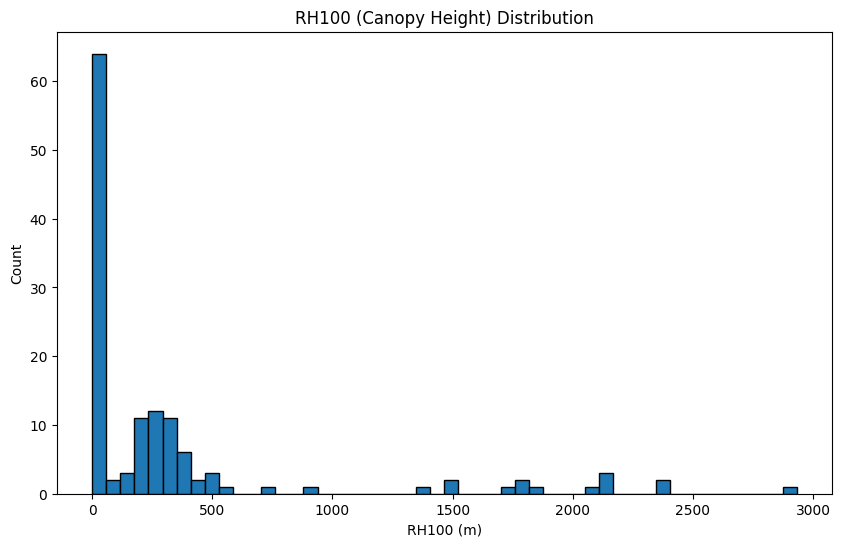

In [ ]:
import h5py
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

gedi_file = "/content/101304459_GEDI02_B_2022103132503_O18884_02_T10864_02_003_01_V002_subsetted.h5"

with h5py.File(gedi_file, 'r') as f:
    beam_keys = [k for k in f.keys() if k.startswith("BEAM")]
    print("Available beams:", beam_keys)

    beam = beam_keys[0]  # use first beam

    print(f"Datasets in {beam}:")
    for k in f[beam].keys():
        print(" -", k)

    print(f"\nDatasets in {beam}/geolocation:")
    for k in f[f"{beam}/geolocation"].keys():
        print(" -", k)

    # Use exact dataset names based on your output
    lat = f[f"{beam}/geolocation/lat_lowestmode"][:]
    lon = f[f"{beam}/geolocation/lon_lowestmode"][:]

    rh100 = f[f"{beam}/rh100"][:]

# Build DataFrame
df = pd.DataFrame({
    "latitude": lat,
    "longitude": lon,
    "rh100": rh100
})

# Clean data
df = df.dropna(subset=["latitude", "longitude", "rh100"])
df = df[(df["latitude"] != 0) & (df["longitude"] != 0)]

print(f"Loaded {len(df)} points from beam {beam}")

# Plot histogram of RH100
plt.figure(figsize=(10,6))
plt.hist(df["rh100"], bins=50, edgecolor='black')
plt.title("RH100 (Canopy Height) Distribution")
plt.xlabel("RH100 (m)")
plt.ylabel("Count")
plt.show()

# Create interactive map
m = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=12)

marker_cluster = MarkerCluster().add_to(m)
max_rh = df["rh100"].max()

for _, row in df.iterrows():
    norm_rh = row["rh100"] / max_rh if max_rh > 0 else 0
    color = plt.cm.viridis(norm_rh)
    hex_color = mcolors.rgb2hex(color[:3])

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        fill=True,
        fill_opacity=0.7,
        color=hex_color,
        popup=f"RH100: {row['rh100']:.2f} m",
    ).add_to(marker_cluster)

m


In [ ]:
# ──────────────────────────────────────────────────────────────
# ✅ 1. Install required packages
# ──────────────────────────────────────────────────────────────
!pip install -q sliderule geopandas folium matplotlib

# ──────────────────────────────────────────────────────────────
# ✅ 2. Import libraries
# ──────────────────────────────────────────────────────────────
import folium
import matplotlib.pyplot as plt
from sliderule import sliderule, gedi
import geopandas as gpd

# ──────────────────────────────────────────────────────────────
# ✅ 3. Initialize SlideRule client
# ──────────────────────────────────────────────────────────────
gedi.init("slideruleearth.io", verbose=True)

# ──────────────────────────────────────────────────────────────
# ✅ 4. Define Area of Interest (AOI)
# ──────────────────────────────────────────────────────────────
# Example: Polygon over Grand Mesa, Colorado
aoi = [
    {"lon": -108.15, "lat": 39.0},
    {"lon": -108.15, "lat": 39.2},
    {"lon": -107.8, "lat": 39.2},
    {"lon": -107.8, "lat": 39.0},
    {"lon": -108.15, "lat": 39.0}
]

# ──────────────────────────────────────────────────────────────
# ✅ 5. Set processing parameters
# ──────────────────────────────────────────────────────────────
parms = {
    "poly": aoi,
    "time_start": "2019-11-14T00:00:00Z",
    "time_end": "2019-11-15T00:00:00Z",
    "beam": "BEAM0101",
    "asset": "gedi",  # Use 'gedi' for public GEDI data
    "track": 0,
    "samples": 0,
    "degrade_flag": 0
}

# ──────────────────────────────────────────────────────────────
# ✅ 6. Request GEDI L2B data from SlideRule
# ──────────────────────────────────────────────────────────────
gdf = gedi.gedi02ap(parms)

# ──────────────────────────────────────────────────────────────
# ✅ 7. Display basic information about the retrieved data
# ──────────────────────────────────────────────────────────────
print(f"Retrieved {len(gdf)} GEDI shots.")
print(gdf.head())

# ──────────────────────────────────────────────────────────────
# ✅ 8. Plot RH100 histogram
# ──────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
gdf['rh100'].hist(bins=50)
plt.title('Distribution of RH100 Values')
plt.xlabel('RH100 (m)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# ──────────────────────────────────────────────────────────────
# ✅ 9. Create interactive map of GEDI shots
# ──────────────────────────────────────────────────────────────
# Calculate the center of the map
center_lat = gdf.geometry.y.mean()
center_lon = gdf.geometry.x.mean()

# Initialize Folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add GEDI shots to the map
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"RH100: {row['rh100']:.2f} m"
    ).add_to(m)

# Display the map
m


Retrieved 0 GEDI shots.
Empty GeoDataFrame
Columns: [geometry]
Index: []


KeyError: 'rh100'

<Figure size 1000x600 with 0 Axes>